In [1]:
import numpy as np
import torch 
import torch.nn as nn

In [2]:
sequence_length = 4
batch_size = 1
input_dim = 512
d_model = 512 # Output of the attention unit for each word
x = torch.randn((batch_size, sequence_length, input_dim))

In [3]:
x.shape

torch.Size([1, 4, 512])

In [4]:
x

tensor([[[-0.3291, -1.2081, -0.9383,  ..., -0.8130, -0.1673,  0.7833],
         [ 1.0337,  0.0502, -0.6402,  ..., -0.4475, -0.5932, -0.3467],
         [ 0.9311, -0.7564, -1.2766,  ...,  0.2758, -0.5427, -1.2825],
         [-1.6686, -0.2311,  0.5470,  ..., -0.0551, -0.9282,  0.6740]]])

In [5]:
qkv_layer = nn.Linear(in_features=input_dim, out_features= 3 * d_model)

In [6]:
qkv = qkv_layer(x)

In [7]:
qkv.shape

torch.Size([1, 4, 1536])

In [8]:
qkv

tensor([[[ 0.5394, -0.6173,  1.0741,  ...,  0.1133,  0.4265,  0.5257],
         [-0.9898, -0.6422,  0.0614,  ...,  0.9905,  0.1241, -0.4120],
         [ 0.2968,  0.3626, -1.2080,  ..., -0.8048, -0.7135,  0.3774],
         [-1.1013,  0.1451, -0.1243,  ..., -0.4113,  0.5547,  0.2546]]],
       grad_fn=<ViewBackward0>)

Text(0.5, 1.0, 'qkv distribution')

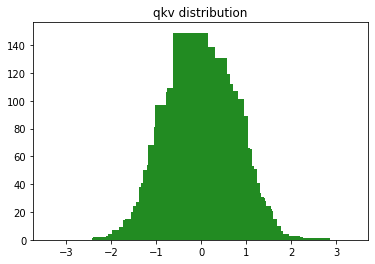

In [9]:
import matplotlib.pyplot as plt
y_val = torch.histc(qkv, bins=200, min=-3, max=3)
x_val = np.arange(-1,1,0.01)*3
plt.bar(x_val, y_val, align='center', color=['forestgreen'])
plt.title("qkv distribution")

In [10]:
num_heads = 8
head_dim = d_model // num_heads
qkv = qkv.reshape(batch_size, sequence_length, num_heads, 3* head_dim)

In [11]:
qkv.shape

torch.Size([1, 4, 8, 192])

In [12]:
qkv = qkv.permute(0,2,1,3) # [batch_size, num_heads, sequence_length, 3*head_dim]
qkv.shape

torch.Size([1, 8, 4, 192])

In [13]:
q,k,v = qkv.chunk(3, dim=-1) # dim = -1 since we are breaking down the last dim into 3 parts
q.shape, k.shape, v.shape

(torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]),
 torch.Size([1, 8, 4, 64]))

### Self Attention for multiple heads

For a single head: 
![self-attention-formula.png](self-attention-formula.png)

In [14]:
import math
d_k = q.shape[-1]
scaled = torch.matmul(q,k.transpose(-2,-1)) / math.sqrt(d_k) # (-2,-1) since we wanted to transpose the last 2 dimensions
scaled.shape

torch.Size([1, 8, 4, 4])

In [15]:
k.transpose(-2,-1).shape

torch.Size([1, 8, 64, 4])

In [16]:
mask = torch.full(scaled.shape, float('-inf'))
mask = torch.triu(mask, diagonal=1)
mask[0][1] # mask for input to a single head

tensor([[0., -inf, -inf, -inf],
        [0., 0., -inf, -inf],
        [0., 0., 0., -inf],
        [0., 0., 0., 0.]])

In [25]:
(scaled + mask)[0][0]

tensor([[ 0.1988,    -inf,    -inf,    -inf],
        [ 0.1615,  0.6117,    -inf,    -inf],
        [-0.3072, -0.3834, -0.3972,    -inf],
        [-0.3465, -0.4201,  0.2673, -0.2421]], grad_fn=<SelectBackward0>)

In [26]:
scaled+= mask

In [29]:
np.exp(0.1615) / (np.exp(0.6117) + np.exp(0.1615))

0.38931321531114976

In [38]:
import torch.nn.functional as F
attention = F.softmax(scaled, dim=-1)

In [41]:
attention[0][0]

tensor([[1.0000, 0.0000, 0.0000, 0.0000],
        [0.3893, 0.6107, 0.0000, 0.0000],
        [0.3520, 0.3262, 0.3217, 0.0000],
        [0.2046, 0.1901, 0.3781, 0.2272]], grad_fn=<SelectBackward0>)

In [42]:
values = torch.matmul(attention,v)
values.shape # 0th dim -> Batch, 1st dim-> Heads, 2nd dim-> Sequence length, 3rd dim-> vectors per word

torch.Size([1, 8, 4, 64])

In [45]:
import math

def scaled_dot_product(q,k,v, mask=None):
    d_k = q.shape[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2))/ math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention, v)
    return values, attention

In [46]:
values, attention = scaled_dot_product(q,k,v, mask=None)

In [47]:
attention.shape

torch.Size([1, 8, 4, 4])

In [48]:
attention[0][0]

tensor([[0.2633, 0.2269, 0.2523, 0.2576],
        [0.2458, 0.3856, 0.1673, 0.2014],
        [0.1964, 0.1820, 0.1795, 0.4421],
        [0.2046, 0.1901, 0.3781, 0.2272]], grad_fn=<SelectBackward0>)

In [49]:
values.shape

torch.Size([1, 8, 4, 64])

In [50]:
values = values.reshape(batch_size, sequence_length, num_heads * head_dim)
values.shape

torch.Size([1, 4, 512])

In [51]:
linear_layer = nn.Linear(d_model, d_model)

In [52]:
out = linear_layer(values)

In [53]:
out.shape

torch.Size([1, 4, 512])

In [54]:
import math

def scaled_dot_product(q,k,v, mask=None):
    d_k = q.shape[-1]
    scaled = torch.matmul(q,k.transpose(-1,-2))/ math.sqrt(d_k)
    if mask is not None:
        scaled += mask
    attention = F.softmax(scaled,dim=-1)
    values = torch.matmul(attention, v)
    return values, attention


class MultiheadAttention(nn.Module):
    def __init__(self, input_dim, d_model, num_heads) -> None:
        super().__init__()
        self.input_dim = input_dim
        self.d_model = d_model
        self.num_heads = num_heads
        self.head_dim = d_model // num_heads
        self.qkv_layer = nn.Linear(input_dim, 3*d_model)
        self.linear_layer = nn.Linear(d_model, d_model)
        
    def forward(self, x, mask=None):
        batch_size, sequence_length, input_dim = x.shape
        print(f"x.shape:{x.shape}")
        qkv = self.qkv_layer(x)
        print(f"qkv.shape:{qkv.shape}")
        qkv = qkv.reshape(batch_size, sequence_length, self.num_heads, 3* self.head_dim)
        print(f"qkv.shape:{qkv.shape}")
        qkv = qkv.permute(0,2,1,3)
        print(f"qkv.shape:{qkv.shape}")
        q,k,v = qkv.chunk(3, dim=-1)
        print(f"q.size:{q.shape} | k.size:{k.shape} | v.size:{v.shape}")
        values, attention = scaled_dot_product(q,k,v,mask)
        print(f"values.shape:{values.shape} | attention.shape:{attention.shape}")
        values = values.reshape(batch_size, sequence_length, self.num_heads* self.head_dim)
        print(f"values.shape:{values.shape}")
        out = self.linear_layer(values)
        print(f"out.shape:{out.shape}")
        return out

In [55]:
input_dim = 1024
d_model = 512
num_heads = 8

batch_size = 30
sequence_length = 5
x = torch.randn((batch_size, sequence_length, input_dim))

model = MultiheadAttention(input_dim, d_model, num_heads)
out = model(x)

x.shape:torch.Size([30, 5, 1024])
qkv.shape:torch.Size([30, 5, 1536])
qkv.shape:torch.Size([30, 5, 8, 192])
qkv.shape:torch.Size([30, 8, 5, 192])
q.size:torch.Size([30, 8, 5, 64]) | k.size:torch.Size([30, 8, 5, 64]) | v.size:torch.Size([30, 8, 5, 64])
values.shape:torch.Size([30, 8, 5, 64]) | attention.shape:torch.Size([30, 8, 5, 5])
values.shape:torch.Size([30, 5, 512])
out.shape:torch.Size([30, 5, 512])
